# Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
import sys
import os

src_path = os.path.abspath("../")
sys.path.append(src_path)

In [5]:
from src.autoencoder import AE

# Data Loader

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Diretório contendo as imagens.
            transform (callable, optional): Transformações a serem aplicadas nas imagens.
        """
        self.image_dir = image_dir
        self.image_paths = [
            os.path.join(image_dir, fname) 
            for fname in os.listdir(image_dir) 
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # Retorna apenas a imagem

# Transformações a serem aplicadas às imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona as imagens
    transforms.ToTensor(),         # Converte para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normaliza
])

# Diretório contendo as imagens
dataset_path = "../data/DAM_white_background"  # Altere para o caminho correto
dataset = CustomImageDataset(dataset_path, transform=transform)

# Divisão do dataset
train_size = int(0.7 * len(dataset))  # 70% para treino
val_size = int(0.15 * len(dataset))   # 15% para validação
test_size = len(dataset) - train_size - val_size  # 15% para teste
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Testando o DataLoader
for batch in train_loader:
    print("Train Batch Shape:", batch.shape)
    break

for batch in val_loader:
    print("Validation Batch Shape:", batch.shape)
    break

for batch in test_loader:
    print("Test Batch Shape:", batch.shape)
    break

Train Batch Shape: torch.Size([32, 3, 224, 224])
Validation Batch Shape: torch.Size([32, 3, 224, 224])
Test Batch Shape: torch.Size([32, 3, 224, 224])


# Training

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = AE(18).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using device: cuda


In [22]:
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Modo de treinamento
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Modo de validação
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon, _ = model(batch)
                loss = criterion(recon, batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [23]:
num_epochs = 50
train_losses, val_losses = train_autoencoder(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)


Epoch [1/50], Train Loss: 2.4570, Val Loss: 2.2792
Epoch [2/50], Train Loss: 2.1743, Val Loss: 2.0422
Epoch [3/50], Train Loss: 2.0101, Val Loss: 1.9190
Epoch [4/50], Train Loss: 1.8565, Val Loss: 1.8183
Epoch [5/50], Train Loss: 1.7291, Val Loss: 1.6520
Epoch [6/50], Train Loss: 1.6219, Val Loss: 1.5294
Epoch [7/50], Train Loss: 1.5154, Val Loss: 1.4690
Epoch [8/50], Train Loss: 1.4368, Val Loss: 1.4408
Epoch [9/50], Train Loss: 1.3566, Val Loss: 1.2911
Epoch [10/50], Train Loss: 1.2931, Val Loss: 1.2730
Epoch [11/50], Train Loss: 1.2433, Val Loss: 1.2196
Epoch [12/50], Train Loss: 1.1944, Val Loss: 1.1809
Epoch [13/50], Train Loss: 1.1555, Val Loss: 1.1500
Epoch [14/50], Train Loss: 1.1202, Val Loss: 1.1393
Epoch [15/50], Train Loss: 1.0953, Val Loss: 1.1305
Epoch [16/50], Train Loss: 1.0800, Val Loss: 1.0897
Epoch [17/50], Train Loss: 1.0565, Val Loss: 1.0813
Epoch [18/50], Train Loss: 1.0359, Val Loss: 1.0718
Epoch [19/50], Train Loss: 1.0278, Val Loss: 1.0400
Epoch [20/50], Train 

Metrics saved!


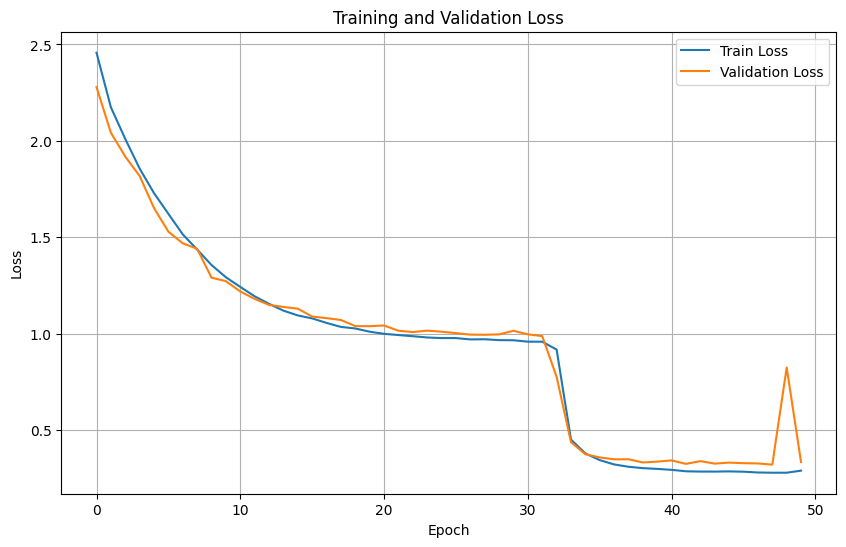

In [24]:
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses
}
torch.save(metrics, "metrics.pth")
print("Metrics saved!")

# Plotando as perdas de treino e validação
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Salvando o modelo treinado
torch.save(model.state_dict(), "autoencoder.pth")
print("Model saved!")


Model saved!


# Evaluation

In [26]:
import matplotlib.pyplot as plt
import torch

def evaluate_autoencoder(model, test_loader, num_images=5):
    model.eval()

    original_images = []
    reconstructed_images = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            reconstructions, _ = model(batch)

            original_images.extend(batch.cpu())
            reconstructed_images.extend(reconstructions.cpu())

            if len(original_images) >= num_images:
                break

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].permute(1, 2, 0).numpy() * 0.229 + 0.485)  # Desnormalizar
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].permute(1, 2, 0).numpy() * 0.229 + 0.485)  # Desnormalizar
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038866967..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.485..1.1482174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16862744..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.485..1.1400962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18431371..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.485..1.1390287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.062745094..1.08956].
Clippi

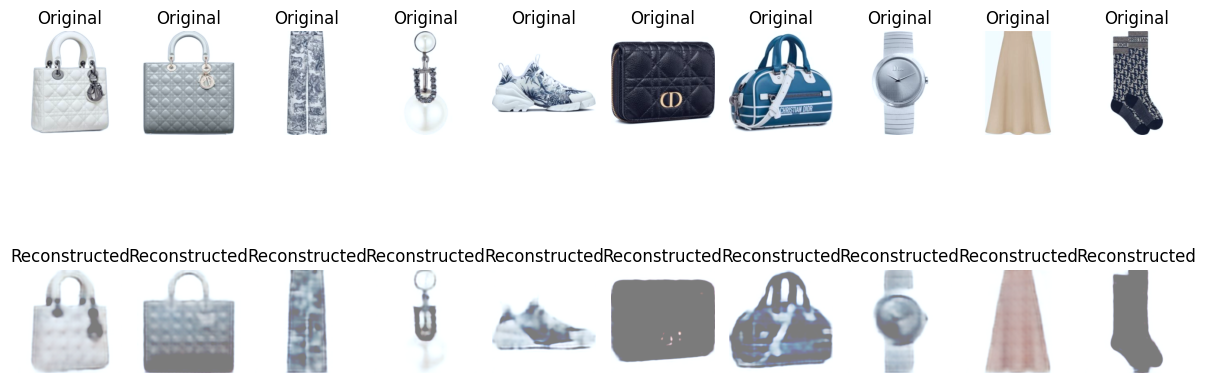

In [27]:
evaluate_autoencoder(model, test_loader, num_images=10)

# Image Retrieval

In [23]:
import torch

def process_embeddings(encoder_output: torch.Tensor) -> torch.Tensor:
    """
    Processa a saída do encoder para obter embeddings de dimensão [batch_size, embedding_dim].
    Aplica global average pooling para reduzir as dimensões espaciais.

    Args:
        encoder_output (torch.Tensor): Saída do encoder no formato [batch_size, channels, height, width].

    Returns:
        torch.Tensor: Embeddings no formato [batch_size, channels].
    """
    # Global Average Pooling: Reduz [batch_size, channels, height, width] para [batch_size, channels]
    embeddings = torch.mean(encoder_output, dim=[2, 3])  # Média nas dimensões height e width
    return embeddings

In [24]:
def generate_and_save_embeddings_with_processing(model, dataloader, save_path="embeddings.pt"):
    """
    Gera e salva embeddings processados de um conjunto de imagens.

    Args:
        model (torch.nn.Module): Modelo autoencoder.
        dataloader (torch.utils.data.DataLoader): Dataloader com as imagens.
        save_path (str): Caminho para salvar os embeddings gerados.
    """
    model.eval()
    embeddings_list = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            _, encoder_output = model(images)  # Obter a saída do encoder
            embeddings = process_embeddings(encoder_output)  # Processar os embeddings
            embeddings_list.append(embeddings.cpu())

    # Concatenar todos os embeddings e salvar
    all_embeddings = torch.cat(embeddings_list, dim=0)
    torch.save(all_embeddings, save_path)
    print(f"Embeddings salvos em: {save_path}")


In [34]:
dataset_path = "../data/DAM_white_background"
dataset = CustomImageDataset(dataset_path, transform=transform)


# DataLoaders
batch_size = 32
image_retrieval_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [31]:
generate_and_save_embeddings_with_processing(model, image_retrieval_loader, save_path="../models/embeddings.pt")


Embeddings salvos em: ../models/embeddings.pt


In [84]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def retrieve_similar_images_cosine(query_embedding, database_embeddings, top_k=5):
    """
    Recupera as imagens mais similares ao embedding de consulta usando similaridade cosseno.

    Args:
        query_embedding (torch.Tensor): Embedding da imagem de consulta (dimensão [embedding_dim]).
        database_embeddings (torch.Tensor): Embeddings do banco de dados (dimensão [num_images, embedding_dim]).
        top_k (int): Número de imagens similares a serem recuperadas.

    Returns:
        List[int]: Índices das imagens mais similares no banco de dados.
    """
    # Normalizar os embeddings para calcular similaridade cosseno

    # Converter embeddings para numpy
    embeddings_numpy = database_embeddings.detach().cpu().numpy()

    query_embedding = query_embedding.detach().cpu().numpy()

    # Calcular similaridade cosseno usando sklearn
    similarities = cosine_similarity(query_embedding.reshape(1, -1), embeddings_numpy).flatten()

    # Obter os índices das imagens mais similares
    top_k_indices = similarities.argsort()[::-1][:top_k]

    return top_k_indices



In [46]:
import matplotlib.pyplot as plt

def visualize_retrieval_cosine(query_image, retrieved_indices, dataset):
    """
    Visualiza a imagem de consulta e as imagens recuperadas usando similaridade cosseno.

    Args:
        query_image (PIL.Image): Imagem de consulta.
        retrieved_indices (List[int]): Índices das imagens recuperadas no dataset.
        dataset (Dataset): Dataset contendo as imagens originais.
    """
    # Mostrar a imagem de consulta
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(retrieved_indices) + 1, 1)
    plt.imshow(query_image.permute(1, 2, 0))  # Permutar dimensões do tensor para (H, W, C)
    plt.title("Query Image")
    plt.axis("off")

    # Mostrar as imagens recuperadas
    for i, idx in enumerate(retrieved_indices):
        retrieved_image = dataset[idx]  # Carregar imagem no formato (C, H, W)
        plt.subplot(1, len(retrieved_indices) + 1, i + 2)
        plt.imshow(retrieved_image.permute(1, 2, 0))  # Permutar dimensões
        plt.title(f"Rank {i + 1}")
        plt.axis("off")

    plt.show()

In [32]:
database_embeddings = torch.load("../models/embeddings.pt").to(device)

C:\Users\merte\AppData\Local\Temp\ipykernel_12964\2031024994.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  database_embeddings = torch.load("../models/embeddings.pt").

In [12]:
model = AE(num_layers=18).to(device)
model.load_state_dict(torch.load("../models/autoencoder.pth"))
print("Model loaded!")

C:\Users\merte\AppData\Local\Temp\ipykernel_12964\2235691541.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/autoencoder.pth"

Model loaded!


In [52]:
test_IR_dataset_path = "../data/preprocessed_test"
test_IR_dataset = CustomImageDataset(test_IR_dataset_path, transform=transform)


# DataLoaders
batch_size = 32
test_image_retrieval_loader = DataLoader(test_IR_dataset, batch_size=batch_size, shuffle=False)

In [79]:
image = Image.open(r'../data/DAM_white_background/01BB01A2102X4847.jpeg').convert("RGB")
query_image = transform(image)

In [99]:
query_image = next(iter(test_image_retrieval_loader))
query_image = query_image[1]

In [100]:
model.eval()
with torch.no_grad():
    _, query_embedding = model(query_image.unsqueeze(0).to(device))  # Adicionar batch dimension
    query_embedding = process_embeddings(query_embedding)

In [101]:
top_k_indices_cosine = retrieve_similar_images_cosine(query_embedding, database_embeddings, top_k=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.64].
Clipping input data t

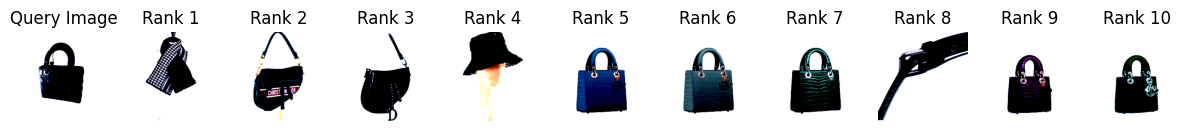

In [102]:
visualize_retrieval_cosine(query_image, top_k_indices_cosine, dataset)